# Signal analysis 

The code in this notebook guides you through signal analysis.

1. Read metadata
2. Create a Probe object
3. Read and cut the neural signal around the stimulus (periStim)
4. Filter the signal and visualize its effects
5. Perform arbitrary spike detection by thresholding
6. Visualize Spikes with a Raster plot

## Data Loading
Import necessary packages, define pathing, read data datafile and extract metadata

In [1]:
# Imports
from helpers import *
from visualization import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import allego_file_reader as afr 
import spikeinterface as si
import spikeinterface.widgets as sw
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.extractors as se 
import spikeinterface.postprocessing as spost
import spikeinterface.exporters as sexp
import probeinterface as pi
import warnings, sys
from pathlib import Path
import os

# Pathing
root = 'G:/NN_data/SNA-128477/ephys/' # Should contain all the data of a single session raw+curated+filtered+preprocessed and sorted
raw_folder = root+'raw/'
raw_path = Path(raw_folder) # Not sure how necessary this is
all_xdat_filesnames = [Path(elem.stem).stem for elem in list(raw_path.glob('**/*xdat.json'))] # This probably contains more files if the ephys folder has info about all sessions
print(f"SpikeInterface version: {si.__version__}")
print(f'XDAT filenames in folder: {all_xdat_filesnames}')

# DEFINE which file you want to analyize 
# From the print above pick a file, I go for 'allego_1__uid0215-14-48-34' and read its metadata
target_file = raw_folder + all_xdat_filesnames[-1] # NOTE: This file is last learning session during microstim, no known depth but with memory performance.

# Extract metadata
metadata = afr.read_allego_xdat_metadata(target_file)
nChannel = metadata['sapiens_base']['sensors_by_port']['A']['num_channels']
fSample = metadata['status']['samp_freq']
TTL_duration = int(0.2 * fSample) # In seconds

# Read in the signaldata
signals, timestamps, time_samples = afr.read_allego_xdat_all_signals(target_file)
print(f'LOADED: {target_file}')


SpikeInterface version: 0.99.1
XDAT filenames in folder: ['allego_0__uid0212-13-53-48', 'allego_0__uid0213-13-47-02', 'allego_0__uid0214-13-48-46', 'allego_1__uid0215-14-48-34']
LOADED: G:/NN_data/SNA-128477/ephys/raw/allego_1__uid0215-14-48-34


## Probe creation
Since you are using multiple probes, maybe create some of them and have them as stored files

In [2]:
probe = createProbe(metadata)
probe_df = probe.to_dataframe()
display(probe_df)
channel_order = probe_df.sort_values(by='y', ascending=True)['contact_ids'].astype(int).to_list()

,x,y,contact_shapes,radius,shank_ids,contact_ids
0,32.25,136.5,circle,50.0,0,1
1,32.25,176.5,circle,50.0,0,2
2,32.25,96.5,circle,50.0,0,3
3,32.25,256.5,circle,50.0,0,4
4,32.25,216.5,circle,50.0,0,5
5,32.25,56.5,circle,50.0,0,6
6,32.25,296.5,circle,50.0,0,7
7,32.25,336.5,circle,50.0,0,8
8,32.25,376.5,circle,50.0,0,9
9,32.25,416.5,circle,50.0,0,10


## Preprocessing
- Perform Common Median referencing and Bandpass filtering (300-5000Hz)
- Create a peristim dataframe by slicing the signal around each stimulus

In [3]:
# Filter
print('Applying filters')
CAR_signals = common_median_referencing(signals)
filt_signals = bandpass_filter(CAR_signals, lowcut=300, highcut=5000, fs=fSample)
print('Done!')

# Create peristim_df with 0.5 seconds before stim onset and 2 seconds after.
raw_periStim_df = get_periStim(signals, order=channel_order, limit=False, start_time=0.5, stop_time=2)
CAR_periStim_df = get_periStim(CAR_signals, order=channel_order, limit=False, start_time=0.5, stop_time=2)
filt_periStim_df = get_periStim(filt_signals, order=channel_order, limit=False, start_time=0.5, stop_time=2)

Applying filters
Done!


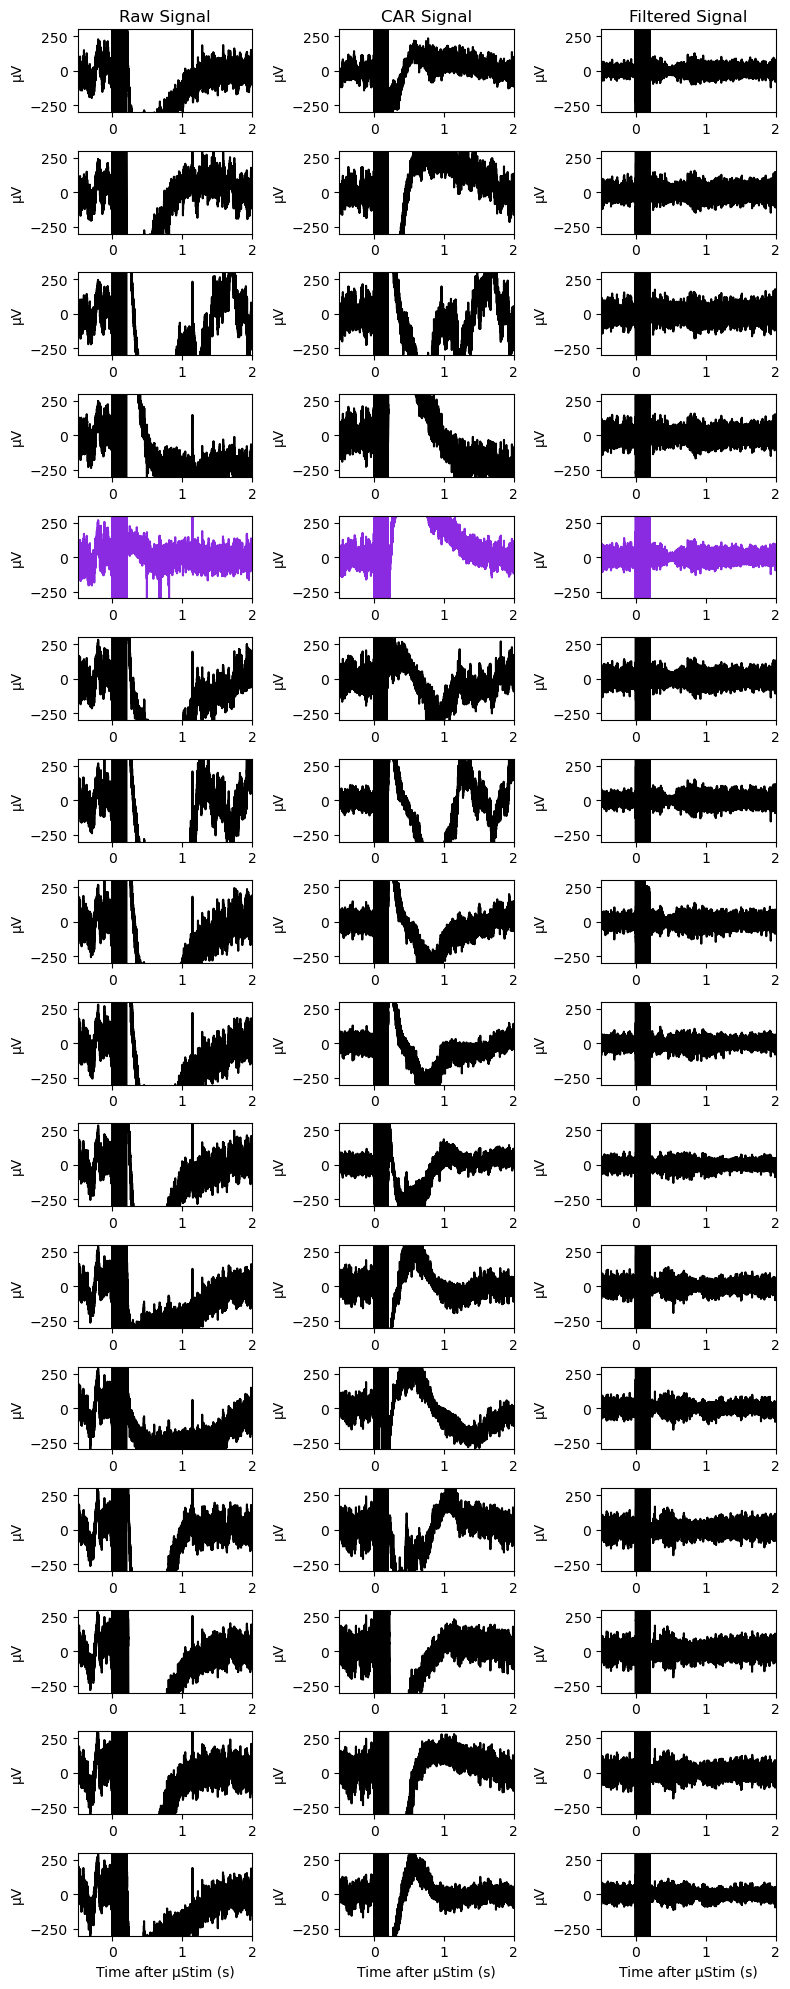

In [4]:
# Show the effect of filtering on the signal
all_periStim_dfs = [raw_periStim_df, CAR_periStim_df, filt_periStim_df]
create_periStim_grid(all_periStim_dfs, stim_idx=0) # Zoomed Random pick of stimulus

## Arbitrarily detect spikes
- Get the variance of the signal from the mean
- Visualise the mean plus minus this variance and determine if that is an alright threshold
- For each point that goes above theshold count it as a spike
    - Make sure that a spike is not counted twice so skip a certain range after a spike is counted
- I take the std from the time before stimulus onset?

[6, 3, 1, 2, 5, 4, 7, 8, 9, 10, 13, 12, 15, 16, 14, 11]


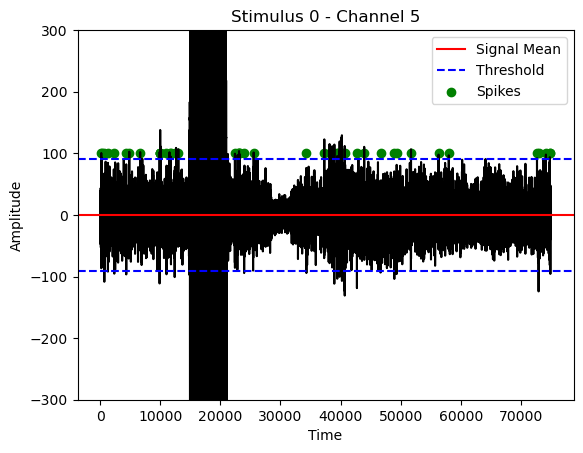

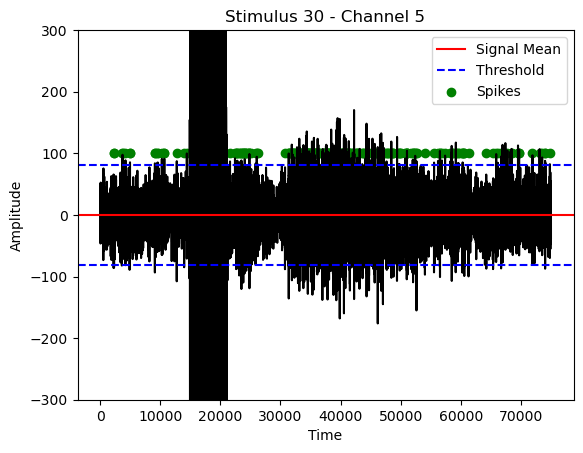

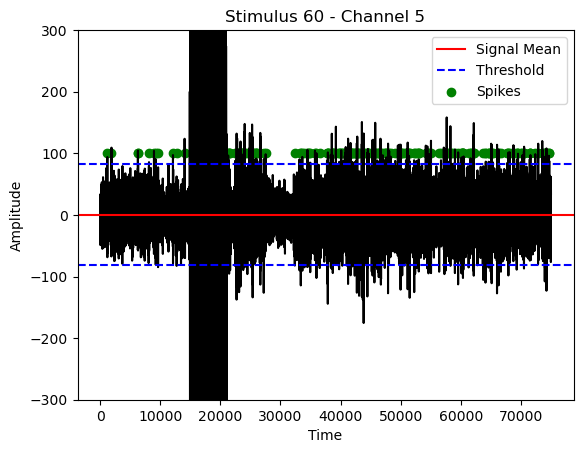

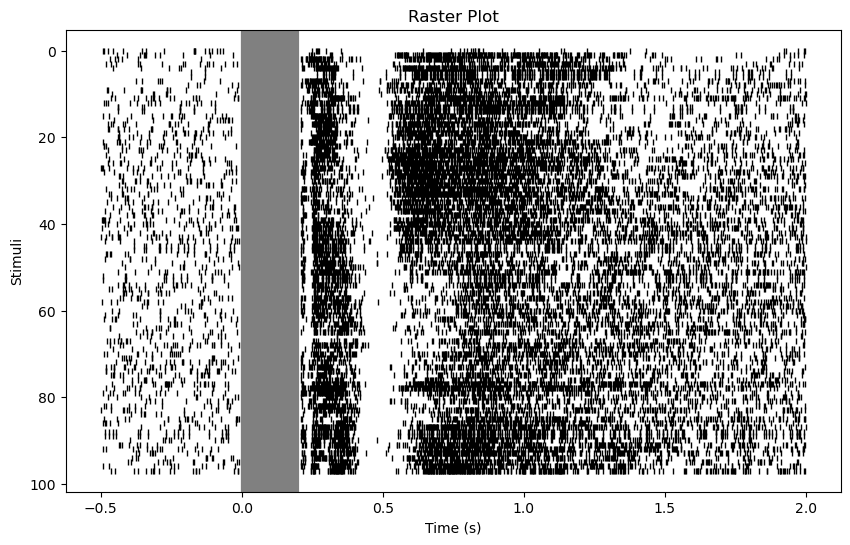

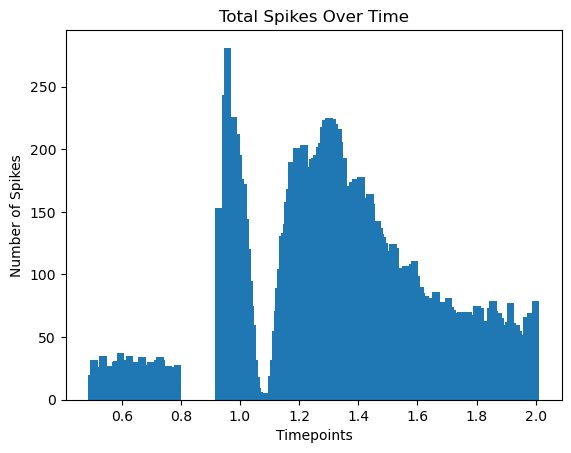

In [5]:
print(channel_order)
# Visualize the effect of thresholding on multiple stimuli
channel = 5
plot_thresholded_spikes(filt_periStim_df, channel_index=channel, indices_to_plot=[0, 30, 60])

# Based on the outcome you can play around with the threshold multiplier
threshold_multiplier = 3.5 

# Plot a rasterplot of all points that cross the threshold
spike_matrix = get_spike_matrix(filt_periStim_df, channel_index=channel, threshold_multiplier=3.5)
plot_raster(spike_matrix)

time_start = 0.5
time_end=2
plot_psth(spike_matrix, fSample, time_start, time_end)


## Kilosorting 